In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import site
import json
import pickle
import matplotlib.colors as mcolors
# Project Parameters
path_to_project = f'../'
path_to_leaspype = f'../../../'
    
# beware to update leaspy submodule with latest dev version
# command: `git submodule update --remote`
site.addsitedir(os.path.join(path_to_leaspype, 'leaspy_refacto'))

#%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
from leaspy import Leaspy, Data, IndividualParameters, AlgorithmSettings, Dataset

# Data

In [3]:
noise= "gaussian_scalar"

In [4]:
list_scenario = [f'P_{i}' for i in [2,3]]\
                + [f'S_{i}' for i in (1,3)] \
                + [f'V_{i}' for i in (1,3)] \
                + [f'F_{i}' for i in (1,3)]\
                + [f'L_{i}' for i in (1,2)] 

params_grouped = ['tau_mean','tau_std','xi_std']
params_alone = ['g', 'v0']
if noise == "gaussian_scalar":
    params_grouped += ['noise_std']
elif noise == "gaussian_diagonal":
    params_alone += ['noise_std']
list_param = params_grouped + params_alone

features = ['ALSFRS_R_BULBAR',
  'ALSFRS_R_FINE_MOTOR',
  'ALSFRS_R_GROSS_MOTOR',
  'ALSFRS_R_RESPIRATORY']

In [5]:
save_path = f"results/{noise}/"
if not os.path.isdir(save_path):
    os.makedirs(save_path)

# Functions

In [6]:
def error_to_sim(results_in, results_sim, list_param, list_scenario, noise, dev = False):
    diff_sim = {}
    for param in list_param:

        diff_sim[param] = []
        for key_file  in list_scenario:
            params_in = results_in[key_file]
            params_sim = results_sim[key_file]
            if param == 'g':
                estim = np.exp(params_in["log_g_mean"])
                sim = np.exp(params_sim[param])

            elif param == 'v0':
                estim = np.exp(params_in["log_v0_mean"])
                if not dev:
                    gk = np.exp(params_sim["g"])
                    sim = np.exp(params_sim[param])/((gk+1)**2)*gk
                else:
                    sim = np.exp(params_sim[param])
            elif param == 'noise_std':
                estim = np.array(params_in[param])
                if noise == "gaussian_scalar":
                    sim = np.array(params_sim[param]).mean()
                else:
                    sim = np.array(params_sim[param])
            else:
                estim = params_in[param][0]
                sim = params_sim[param]
            diff_sim[param].append( 100*(estim - sim)/sim)
        diff_sim[param] = np.array(diff_sim[param])
    return diff_sim

# Load results

In [7]:
results_dev = pickle.load( open( f"../2_fit/{noise}/dev/results.p", "rb" ) )
results_v2 = pickle.load( open( f"../2_fit/{noise}/v2/results.p", "rb" ) )
results_v2_fixed = pickle.load( open( f"../2_fit/{noise}/jo_fix_test_refacto/results.p", "rb" ) )

results_sim = {}
for key_file in list_scenario:
    # Get real parameters
    path_real_params = f'../1_sim_gen/sim_checks/{key_file}/params_simulated.json'
    with open(path_real_params) as file:
          sim_params = json.load(file)
    results_sim[key_file] = sim_params['repeated_measure']['parameters']


# Plot mode difference % to simulation (v2 & v2_fixed)

In [8]:
diff_sim_v2 = error_to_sim(results_v2, results_sim, list_param, list_scenario, noise)
diff_sim_v2_fixed = error_to_sim(results_v2_fixed, results_sim, list_param, list_scenario, noise)

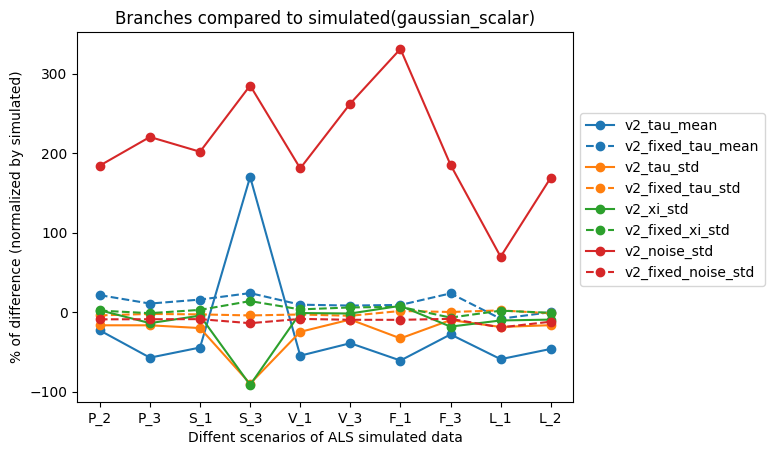

In [9]:
for i, param in enumerate(params_grouped):
    plt.plot(np.arange(len(diff_sim_v2[param])), np.array(diff_sim_v2[param]), 
                 label = 'v2_'+param, marker="o", color = list(mcolors.TABLEAU_COLORS.keys())[i])
    plt.plot(np.arange(len(diff_sim_v2_fixed[param])), np.array(diff_sim_v2_fixed[param]), 
                 label = 'v2_fixed_'+param, marker="o", color = list(mcolors.TABLEAU_COLORS.keys())[i],
                linestyle='dashed')
    
plt.xticks(np.arange(len(list_scenario)), list_scenario)
plt.legend(bbox_to_anchor=(1, 0.8))
plt.ylabel('% of difference (normalized by simulated)')
plt.xlabel('Diffent scenarios of ALS simulated data')
plt.title(f'Branches compared to simulated({noise})')
plt.savefig(f"{save_path}sim_grouped.png", bbox_inches='tight')
#plt.ylim(-700, 600)
plt.show()

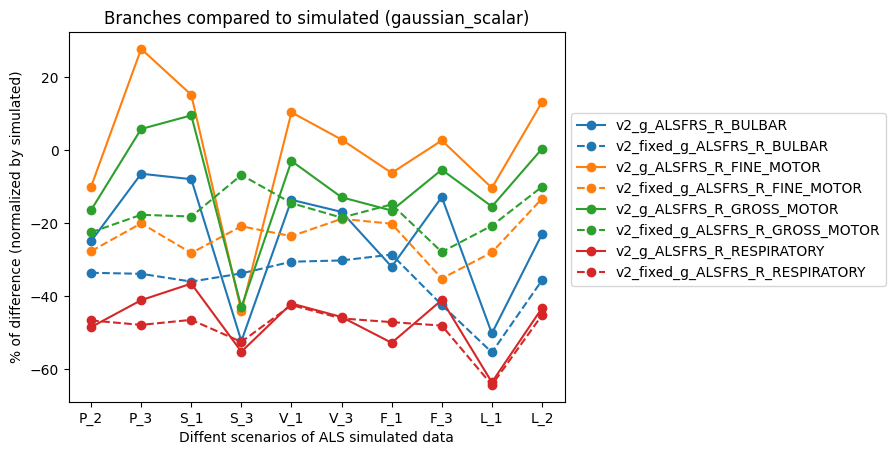

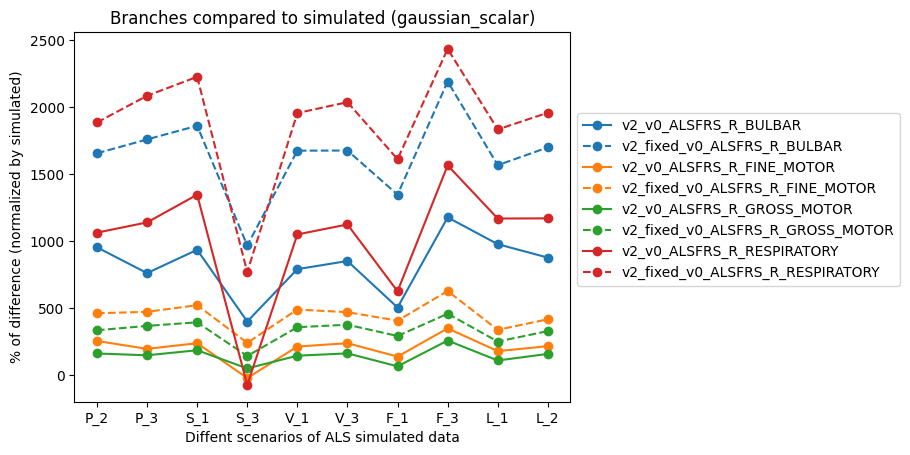

In [10]:
for param in params_alone:
    for i, feat in enumerate(features):
        plt.plot(np.arange(len(diff_sim_v2[param])), np.array(diff_sim_v2[param])[:,i], 
                     label = f'v2_{param}_{feat}', marker="o", color = list(mcolors.TABLEAU_COLORS.keys())[i])
        plt.plot(np.arange(len(diff_sim_v2_fixed[param])), np.array(diff_sim_v2_fixed[param])[:,i],  
                     label = f'v2_fixed_{param}_{feat}', marker="o", color = list(mcolors.TABLEAU_COLORS.keys())[i],
                    linestyle='dashed')

    plt.xticks(np.arange(len(list_scenario)), list_scenario)
    plt.legend(bbox_to_anchor=(1, 0.8))
    plt.ylabel('% of difference (normalized by simulated)')
    plt.xlabel('Diffent scenarios of ALS simulated data')
    plt.title(f'Branches compared to simulated ({noise})')
    plt.savefig(f"{save_path}sim_alone_{param}.png", bbox_inches='tight',)
    #plt.ylim(-700, 600)
    plt.show()

# 

# Plot mode difference % to dev  (v2 & v2_fixed)


In [11]:
diff_dev_v2 = error_to_sim(results_v2, results_dev, list_param, list_scenario, noise, dev = True)
diff_dev_v2_fixed = error_to_sim(results_v2_fixed, results_dev, list_param, list_scenario, noise, dev = True)

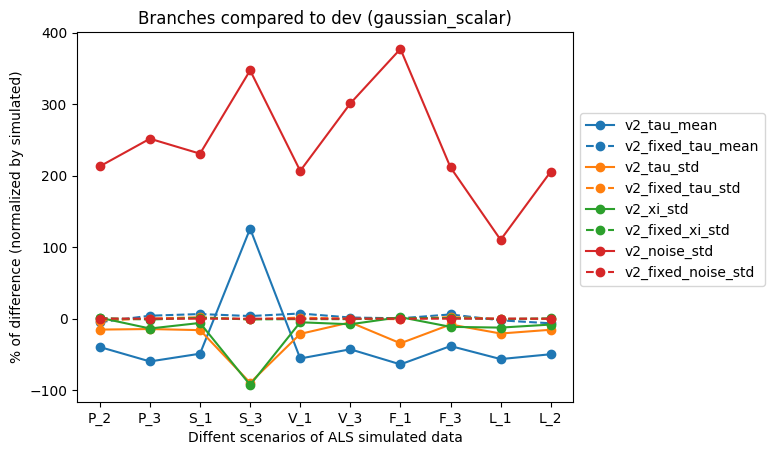

In [12]:
for i, param in enumerate(params_grouped):
    plt.plot(np.arange(len(diff_dev_v2[param])), np.array(diff_dev_v2[param]), 
                 label = 'v2_'+param, marker="o", color = list(mcolors.TABLEAU_COLORS.keys())[i])
    plt.plot(np.arange(len(diff_dev_v2_fixed[param])), np.array(diff_dev_v2_fixed[param]), 
                 label = 'v2_fixed_'+param, marker="o", color = list(mcolors.TABLEAU_COLORS.keys())[i],
                linestyle='dashed')
    
plt.xticks(np.arange(len(list_scenario)), list_scenario)
plt.legend(bbox_to_anchor=(1, 0.8))
plt.ylabel('% of difference (normalized by simulated)')
plt.xlabel('Diffent scenarios of ALS simulated data')
plt.title(f'Branches compared to dev ({noise})')
plt.savefig(f"{save_path}dev_grouped.png", bbox_inches='tight')
#plt.ylim(-700, 600)
plt.show()

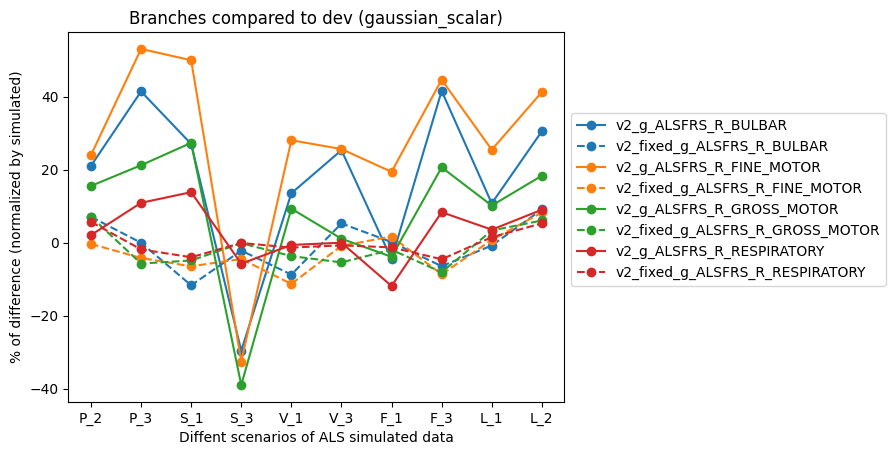

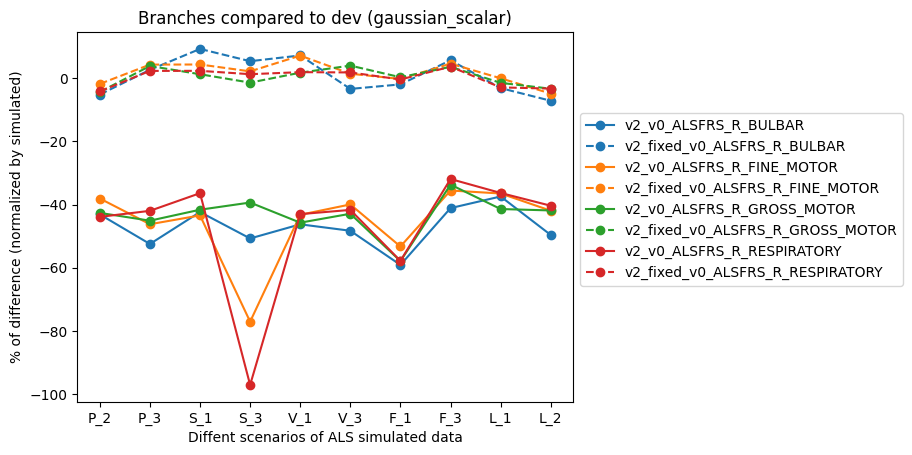

In [13]:
for param in params_alone:
    for i, feat in enumerate(features):
        plt.plot(np.arange(len(diff_dev_v2[param])), np.array(diff_dev_v2[param])[:,i], 
                     label = f'v2_{param}_{feat}', marker="o", color = list(mcolors.TABLEAU_COLORS.keys())[i])
        plt.plot(np.arange(len(diff_dev_v2_fixed[param])), np.array(diff_dev_v2_fixed[param])[:,i],  
                     label = f'v2_fixed_{param}_{feat}', marker="o", color = list(mcolors.TABLEAU_COLORS.keys())[i],
                    linestyle='dashed')

    plt.xticks(np.arange(len(list_scenario)), list_scenario)
    plt.legend(bbox_to_anchor=(1, 0.8))
    plt.ylabel('% of difference (normalized by simulated)')
    plt.xlabel('Diffent scenarios of ALS simulated data')
    plt.title(f'Branches compared to dev ({noise})')
    plt.savefig(f"{save_path}dev_alone_{param}.png", bbox_inches='tight',)
    #plt.ylim(-700, 600)
    plt.show()